# Devoir maison n°5 : lien entre la densité de médecins par spécialité  et par territoire et la pratique du dépassement d'honoraires

Guillaume MOHR

## Préliminaires

In [337]:
import pandas as pd
import numpy as np
import seaborn as sns
from difflib import SequenceMatcher as SM
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Chargement des données

Nous nous concentrerons sur deux jeux de données publics qui nous semblent pertinents afin d'aborder la problématique :
1. les dépenses d'assurance maladie hors prestations hospitalières par caisse primair / département
2. la densité de médecins par spécialité par département

#### Chargement du fichier des dépenses d' assurance maladie hors prestations hospitalières par caisse primaire/département (2014)
Source: https://www.data.gouv.fr/fr/datasets/depenses-d-assurance-maladie-hors-prestations-hospitalieres-par-caisse-primaire-departement/.

Les données étant très larges, on télécharge uniquement les données *sans libellés*, ce qui nous obligera en revanche à rechercher la signification des codes dans des tables à part. Afin de ne pas générer de problèmes de lag lors des tests de ce notebook, nous nous limiterons au moins de 01/2014 (le faire pour l'année entière demanderait juste plus de temps de calcul et une simple concaténation des fichiers).

Les données représentent néanmoins environ **250 Mo par mois de l'année**. Il nous est donc nécessaire de faire le tri afin de n'extraire que ce qui nous intéresse potentiellement. Nous nous aidons pour cela du fichier descriptif des colonnes.

In [3]:
desc = pd.read_excel('data/descriptif_table_R.xls', sheetname='variables ')

In [4]:
desc

,variable,libellé,description
0,act_coe,coefficient global,Une partie des actes de soins est décrite par\...
1,act_dnb,dénombrement,Une partie des actes peut être dénombrée car c...
2,asu_nat,nature d'assurance,Risque au titre duquel est prise en charge la ...
3,ben_qlt,qualité du bénéficiaire,Cette variable distingue les bénéficaires assu...
4,cpam,cpam d'affiliation du bénéficiaire,Numéro de la Caisse Primaire d'Assurance Malad...
5,cpl_cod,complement d'acte,Cette variable permet de toper les suppléments...
6,dep_mon,dépassement d'honoraires,On parle de montant de dépassement lorsque les...
7,dpt,département d'affiliation du bénéficiaire,NaN
8,exe_spe,spécialité exécutant,Spécialité exercée par le médecin (généraliste...
9,exe_spe1,regroupement spécialité exécutant,Spécialité regroupée par grande catégorie d'ex...


Dans la suite nous retiendrons les colonnes suivantes :
- cpam : pour la localisation
- dep_mon : afin d'identifier la présence de dépassement d'honoraire
- exe_spe : la spécialité du médecin exécutant (on n'étudiera pas les médecins prescripteurs)
- exe_spe1 : categorie plus globale, potentiellement utile
- exe_stj1 : afin de savoir si l'exécutant est salarié ou libéral
- prs_nat : la nature de la prestation
- rec_mon : la base de remboursement
- rem_tau : le taux de remboursement de l'assurance maladie

In [5]:
dep = pd.read_csv('data/R201401_sanslib.CSV', encoding='latin9', sep=';', thousands='.', decimal=',',
                  usecols=['cpam', 'dep_mon', 'exe_spe', 'exe_spe1', 'exe_stj1', 'prs_nat',
                           'rec_mon', 'REM_TAU'])

Chargeons un dictionnaire de series de labels afin de pouvoir identifier les codes lorsque nécessaire.

In [6]:
def get_labels(filename):
    return pd.read_csv('data/Lexique_tables_R/'+filename, encoding='latin9', sep=';', index_col=0)

#labels = {'prs_nat': pd.read_csv(('data/Lexique_tables_R/lib_r_exe_spe.csv', encoding='latin9', sep=';'))

In [157]:
labels = {'cpam': get_labels('cpam.csv'),
          'prs_nat': get_labels('lib_prs_nat.csv'),
          'exe_spe': get_labels('lib_r_exe_spe.csv'),
          'exe_spe1': get_labels('lib_exe_spe1.csv'),
          'exe_stj1': get_labels('lib_exe_stj1.csv')}

Profitons-en pour créer une colonne **departement** (avec le numéro de département) à partir de la colonne **cpam**.

In [30]:
dep['departement'] = labels['cpam'].ix[dep.cpam].dpt.values

In [32]:
dep.drop('cpam', axis=1, inplace=True)

In [33]:
dep.head()

,prs_nat,REM_TAU,exe_spe,exe_spe1,exe_stj1,rec_mon,dep_mon,departement
0,1111,30,1,11,1,22.00,0.00,34
1,1111,30,1,11,1,-22.00,0.00,45
2,1111,30,1,11,1,-22.00,0.00,59
3,1111,30,1,11,1,-44.00,0.00,59
4,1111,30,1,11,1,0.43,84.57,61


Groupons par département, specialité (somme et moyennes).

In [415]:
average_dep_dpt = dep.groupby('departement')['dep_mon'].mean()
average_dep_spe = dep.groupby('exe_spe')['dep_mon'].mean()
#sum_dep = dep.groupby(['departement', 'exe_spe'])['dep_mon'].sum()

#### Chargement du fichier de densité des médecins par spécialité, modes d'exercice regroupés et zone d'inscription :   http://www.data.drees.sante.gouv.fr/TableViewer/tableView.aspx?ReportId=1155

In [377]:
rpps = pd.read_csv('data/rpps-medecin-tab7-densite-2013-14-15-v1_26900592310704.csv', 
                   encoding='latin9', skiprows=[0, 1, 2, 3, 5])
rpps.rename(columns={'SPECIALITE': 'ZoneInscription'}, inplace=True)

In [378]:
rpps.head()

,ZoneInscription,Ensemble des spécialités d'exercice,Spécialistes,Anatomie et cytologie pathologiques,Anesthésie-réanimation,Biologie médicale,Cardiologie et maladies vasculaires,Chirurgie générale,Chirurgie maxillo-faciale et stomatologie,Chirurgie orthopédique et traumatologie,...,Pneumologie,Psychiatrie,Radio-diagnostic et imagerie médicale,Radio-thérapie,Réanimation médicale,Recherche médicale,Rhumatologie,Santé publique et médecine sociale,Généralistes,Médecine générale
0,FRANCE ENTIERE,336.5,181.3,2.4,16.9,4.4,10.4,5.5,1.8,4.8,...,4.5,22.8,13.0,1.3,0.5,0.0,3.9,2.6,155.2,155.2
1,FRANCE Métropolitaine,339.1,183.2,2.4,17.0,4.5,10.6,5.5,1.8,4.8,...,4.5,23.1,13.1,1.3,0.5,0.0,4.0,2.6,155.9,155.9
2,Alsace,356.9,198.2,2.0,19.9,3.9,12.1,7.1,0.8,5.1,...,4.5,21.7,15.5,1.5,0.9,0.1,3.5,2.3,158.7,158.7
3,Aquitaine,354.3,184.2,2.8,17.9,4.9,11.8,5.2,1.6,5.3,...,3.5,25.5,14.5,1.3,0.2,0.0,3.0,2.5,170.1,170.1
4,Auvergne,308.4,155.5,2.3,16.0,3.6,8.8,5.4,0.7,4.3,...,3.3,18.5,11.0,1.7,0.7,0.0,4.0,2.5,152.9,152.9


Cherchons à faire correspondre les noms des colomnes aux codes des spécialités du tableau précédent.

In [379]:
code_spe = pd.DataFrame(rpps.columns[3:], columns=['label_rpps'])

def best_match(name, limit=0.5):
    scores = [SM(a=name, b=c).ratio() for c in labels['exe_spe']['l_exe_spe']]
    imatch = np.argmax(scores)
    return labels['exe_spe']['l_exe_spe'].iloc[imatch]

code_spe['code_name'] = code_spe['label_rpps'].map(best_match)
#labels['exe_spe']['l_exe_spe'].map(best_match)

On observe que si certaines correspondances se font bien, ce n'est pas parfait. Nous complétons donc à la main. Les spécialités du premier tableau pour lesquelles aucune correspondance ne sera trouvée seront exclues de l'analyse (exemple : ambulancier, taxi).

In [380]:
code_spe.ix[2, 1] = '38-Médecin biologiste'
code_spe.ix[4, 1] = '04-TOTAL Chirurgie'
code_spe.ix[5, 1] = '19-TOTAL Chirurgie dentaire'
code_spe.ix[6, 1] = '04-TOTAL Chirurgie'
code_spe.ix[7, 1] = '04-TOTAL Chirurgie'
code_spe.ix[8, 1] = '04-TOTAL Chirurgie'
code_spe.ix[9, 1] = '04-TOTAL Chirurgie'
code_spe.ix[10, 1] = '04-TOTAL Chirurgie'
code_spe.ix[11, 1] = '04-TOTAL Chirurgie'
code_spe.ix[12, 1] = '04-TOTAL Chirurgie'
code_spe.ix[15, 1] = '00-Sans objet'
code_spe.ix[19, 1] = '00-Sans objet'
code_spe.ix[21, 1] = '01-TOTAL Omnipraticiens'
code_spe.ix[23, 1] = '00-Sans objet'
code_spe.ix[26, 1] = '04-TOTAL Chirurgie'
code_spe.ix[28, 1] = '11-Oto-rhino laryngologie'
code_spe.ix[29, 1] = '00-Sans objet'
code_spe.ix[34, 1] = '06-TOTAL Radiologie'
code_spe.ix[35, 1] = '00-Sans objet'
code_spe.ix[37, 1] = '00-Sans objet'
code_spe.ix[40, 1] = '01-TOTAL Omnipraticiens'
code_spe.ix[41, 1] = '01-TOTAL Omnipraticiens'

In [381]:
a = labels['exe_spe']
rev_codes = pd.DataFrame(data=a.index, index=a.l_exe_spe)

In [382]:
code_spe = code_spe.join(rev_codes, on='code_name')

In [383]:
code_spe

,label_rpps,code_name,exe_spe
0,Anatomie et cytologie pathologiques,37-Anatomie-cytologie-pathologique,37
1,Anesthésie-réanimation,02-total Anesthésiologie - Réanimation chirurg...,2
2,Biologie médicale,38-Médecin biologiste,38
3,Cardiologie et maladies vasculaires,03-Pathologie cardio-vasculaire,3
4,Chirurgie générale,04-TOTAL Chirurgie,4
5,Chirurgie maxillo-faciale et stomatologie,19-TOTAL Chirurgie dentaire,19
6,Chirurgie orthopédique et traumatologie,04-TOTAL Chirurgie,4
7,Chirurgie infantile,04-TOTAL Chirurgie,4
8,Chirurgie plastique reconstructrice et esthétique,04-TOTAL Chirurgie,4
9,Chirurgie thoracique et cardio-vasculaire,04-TOTAL Chirurgie,4


In [384]:
code_spe = code_spe.set_index('label_rpps')

Supprimons donc de notre base de données les codes que nous n'avons pas pu affecter :

In [385]:
a = set(code_spe.code_name.unique())
b = set(labels['exe_spe'].ix[dep.exe_spe].l_exe_spe.unique())
c = set.difference(b, a)
print(c)

{'29-Orthoptiste', '26-Masseur-kinésithérapeute', '65-Titre II, chapitre. 3 audioprothèses', '21-Sages-femmes', '27-Pédicure podologue', '18-TOTAL Stomatologie', '36-Chirurgie dentaire spécialistes', '63-Titre II, chapitre. I orthèses', '60-Titre I, titre II ch. 4, titre IV société', '30-TOTAL Laboratoire', '56-Taxi', '24-Infirmier', '28-Orthophoniste'}


Nous effectuons un *melt* sur la table et une jointure avec code_spe.

In [386]:
rpps = pd.melt(rpps, id_vars='ZoneInscription', var_name='Specialite', value_name='Densite')

In [387]:
rpps = rpps.join(code_spe, on='Specialite').dropna()

On extrait les lignes avec département, et on crée une colonne avec les numéros de départements.

In [388]:
rpps_dep = rpps.sort_values(by='ZoneInscription').iloc[:4242,:].copy()

In [389]:
rpps_dep.head()

,ZoneInscription,Specialite,Densite,code_name,exe_spe
2629,01 - Ain,Gynécologie-obstétrique,7.1,07-TOTAL Gynécologie,7
2759,01 - Ain,Hématologie,0.3,00-Sans objet,99
4969,01 - Ain,Réanimation médicale,0.2,02-total Anesthésiologie - Réanimation chirurg...,2
2889,01 - Ain,Gastro-entérologie et hépatologie,2.4,08-Gastro-entérologie et hépatologie,8
3019,01 - Ain,Médecine du travail,8.4,01-TOTAL Omnipraticiens,1


In [390]:
rpps_dep['departement'] = rpps_dep['ZoneInscription'].map(lambda s: s.split(' ')[0])

def delete_zero(s):
    if len(s) > 0 and s[0] == '0':
        return s[1:]
    else:
        return s
    
rpps_dep['departement'] = rpps_dep['departement'].map(delete_zero)

In [392]:
density_dpt = rpps_dep.groupby('departement')['Densite'].mean()
density_spe = rpps_dep.groupby('exe_spe')['Densite'].mean()

##  Analyse

### Par département

In [405]:
data = pd.DataFrame(average_dep_dpt).join(density_dpt)
data = data.rename(columns={'dep_mon': 'DepassementMoyen'})

DepassementMoyen vs Densité pour les départements français


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


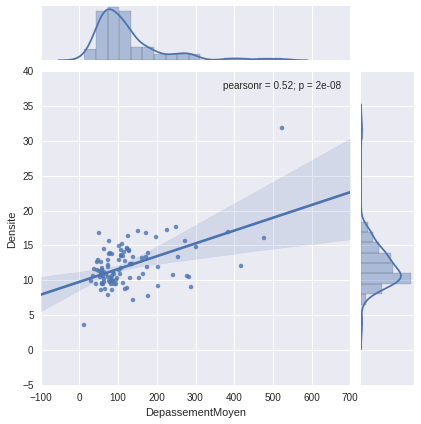

In [430]:
print('DepassementMoyen vs Densité pour les départements français')
sns.jointplot('DepassementMoyen', 'Densite', data, kind="reg")

On observe a priori une correlation entre la densité des médecins et le montant moyen des dépassements. Plus le département est dense en praticiens, plus les dépassements sont élevés.

### Par spécialité

In [457]:
data2 = pd.DataFrame(density_spe).join(average_dep_spe)
data2 = data2.join(labels['exe_spe'])
data2 = data2.rename(columns={'dep_mon': 'DepassementMoyen',
                              'l_exe_spe': 'Specialite'})
data2 = data2.sort_values(by='DepassementMoyen', ascending=False)

Observons d'abord la distribution des dépassements moyen par spécialités.

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


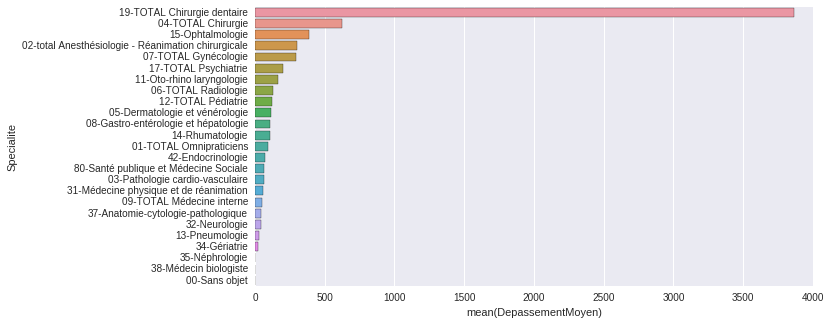

In [458]:
plt.figure(figsize=(10,5))
sns.barplot(x='DepassementMoyen', y='Specialite', data=data2)

On observe clairement que la spécialité *chirurgie dentaire* affiche des dépassements moyens bien supérieurs aux autres spécialités. Nous le considérons pour la suite comme un *outlier* pour le problème posé.

In [459]:
data2p = data2[data2.Specialite != '19-TOTAL Chirurgie dentaire']

/usr/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


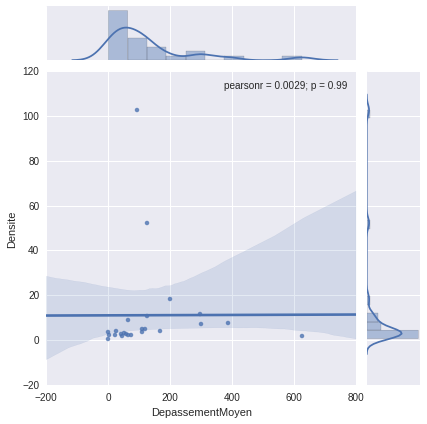

In [460]:
sns.jointplot('DepassementMoyen', 'Densite', data2p, kind="reg")

Même en supprimer l'outlier, la relation entre les dépassement et la densité des praticiens n'est pas évidente et semble même inversée pour certaines professions (par rapport à ce qu'on observait pour les départements). En effet par exemple les médecins généralistes affichent relativement peu de dépassements en moyenne mais sont très concentrés. Les chirurgiens (dentaires ou autres) sont au contraire peu densément répartis mais pratiquent abondemment les dépassements. 

In [461]:
data2

,Densite,DepassementMoyen,Specialite
exe_spe,,,
19,1.365347,3862.286168,19-TOTAL Chirurgie dentaire
4,1.669857,624.239720,04-TOTAL Chirurgie
15,7.503960,386.693097,15-Ophtalmologie
2,7.324257,299.474207,02-total Anesthésiologie - Réanimation chirurg...
7,11.651980,295.275507,07-TOTAL Gynécologie
17,18.253465,198.714013,17-TOTAL Psychiatrie
11,3.940594,166.276308,11-Oto-rhino laryngologie
6,10.911881,126.080177,06-TOTAL Radiologie
12,52.233663,125.532866,12-TOTAL Pédiatrie
